# Разработка интеллектуальной системы поддержки принятия решений на основе нейросетевого анализа временных рядов финансовых инструментов

## 1. Получение данных о финансовых инструментах

Первым шагом в разработке системы является получение актуальной информации о финансовых инструментах от брокера. 

Для работы с API Тинькофф Инвестиций используется официальная Python-библиотека `tinkoff-invest`, которая предоставляет gRPC-клиент для взаимодействия с брокером.

### Источники данных

Система работает со следующими типами инструментов:
- **Акции (shares)** — основные торгуемые инструменты индекса IMOEX
- **Фьючерсы (futures)** — производные инструменты для хеджирования и спекуляций

### Скрипт generate_instruments.py

Скрипт `scripts/generate_instruments.py` автоматизирует процесс получения метаданных инструментов и обновления конфигурации проекта.


In [1]:
# Импорт необходимых библиотек для работы с API брокера
import sys
sys.path.insert(0, '..')

from tinkoff.invest import Client
from tinkoff.invest.schemas import InstrumentStatus
from settings import INVEST_TOKEN

# Подключение к API Тинькофф Инвестиций
with Client(INVEST_TOKEN) as client:
    # Получение списка доступных акций
    shares_response = client.instruments.shares(
        instrument_status=InstrumentStatus.INSTRUMENT_STATUS_BASE
    )
    print(f"Получено акций: {len(shares_response.instruments)}")
    
    # Получение списка доступных фьючерсов
    futures_response = client.instruments.futures(
        instrument_status=InstrumentStatus.INSTRUMENT_STATUS_BASE
    )
    print(f"Получено фьючерсов: {len(futures_response.instruments)}")


Получено акций: 1928
Получено фьючерсов: 495


### Структура данных инструмента

Каждый инструмент содержит следующие ключевые атрибуты:

| Поле | Описание |
|------|----------|
| `ticker` | Биржевой тикер инструмента (например, SBER, GAZP) |
| `figi` | Глобальный идентификатор финансового инструмента (Financial Instrument Global Identifier) |
| `name` | Полное наименование инструмента |
| `class_code` | Код режима торгов на бирже (TQBR — основной режим торгов акциями, SPBFUT — фьючерсы) |
| `lot` | Размер лота |
| `currency` | Валюта номинала |

Давайте посмотрим на пример данных для одного инструмента:


In [2]:
# Поиск и вывод информации о конкретном инструменте (Сбербанк)
with Client(INVEST_TOKEN) as client:
    shares_response = client.instruments.shares(
        instrument_status=InstrumentStatus.INSTRUMENT_STATUS_BASE
    )
    
    # Ищем Сбербанк по тикеру
    sber = next(
        (share for share in shares_response.instruments if share.ticker == "SBER"),
        None
    )
    
    if sber:
        print("Пример данных инструмента (SBER):")
        print(f"  Тикер: {sber.ticker}")
        print(f"  FIGI: {sber.figi}")
        print(f"  Название: {sber.name}")
        print(f"  Код режима торгов: {sber.class_code}")
        print(f"  Лот: {sber.lot}")
        print(f"  Валюта: {sber.currency}")
        print(f"  Сектор: {sber.sector}")


Пример данных инструмента (SBER):
  Тикер: SBER
  FIGI: BBG004730N88
  Название: Сбер Банк
  Код режима торгов: TQBR
  Лот: 1
  Валюта: rub
  Сектор: financial


### Выбор инструментов для анализа

Для системы поддержки принятия решений мы используем инструменты, входящие в **индекс Московской биржи (IMOEX)**. Это обеспечивает:

1. **Ликвидность** — высокий объём торгов и узкие спреды
2. **Доступность данных** — надёжные исторические данные
3. **Репрезентативность** — отражение состояния российского фондового рынка

#### Алгоритм выбора инструментов

При наличии нескольких инструментов с одинаковым тикером (например, на разных биржевых площадках), используется приоритет кодов режимов торгов:


In [3]:
# Конфигурация тикеров для анализа (из generate_instruments.py)
ASSETS = [
    "IMOEXF",  # Фьючерс на индекс MOEX
    "AFKS", "AFLT", "ALRS", "ASTR", "BSPB", "CBOM", "CHMF",
    "ENPG", "FEES", "FLOT", "GAZP", "GMKN", "HEAD", "HYDR",
    "IRAO", "LEAS", "LKOH", "MAGN", "MGNT", "MOEX", "MSNG",
    "MTLR", "MTSS", "NLMK", "NVTK", "PHOR", "PIKK", "PLZL",
    "POSI", "ROSN", "RTKM", "RUAL", "SBER", "SELG", "SMLT",
    "SNGS", "SVCB", "T", "TATN", "UGLD", "UPRO", "VKCO", "VTBR", "YDEX"
]

# Приоритет кодов режимов торгов (MOEX class codes)
PREFERRED_CLASS_CODES = [
    "TQBR",   # Основной режим торгов акциями
    "TQTF",   # Режим торгов ETF
    "TQTD",   # Режим торгов депозитарными расписками
    "TQTE",   # Режим торгов иностранными ETF
    "TQIF",   # Режим торгов ПИФами
    "TQPI",   # Режим торгов паями
    "TQBD",   # Режим торгов облигациями
    "EQNE",   # Внесписочный режим
    "SPBXM",  # Режим SPB Exchange
    "SPBB",   # Режим SPB Биржи
]

print(f"Количество тикеров для анализа: {len(ASSETS)}")
print(f"Тикеры: {', '.join(ASSETS)}")


Количество тикеров для анализа: 45
Тикеры: IMOEXF, AFKS, AFLT, ALRS, ASTR, BSPB, CBOM, CHMF, ENPG, FEES, FLOT, GAZP, GMKN, HEAD, HYDR, IRAO, LEAS, LKOH, MAGN, MGNT, MOEX, MSNG, MTLR, MTSS, NLMK, NVTK, PHOR, PIKK, PLZL, POSI, ROSN, RTKM, RUAL, SBER, SELG, SMLT, SNGS, SVCB, T, TATN, UGLD, UPRO, VKCO, VTBR, YDEX


### Формирование списка инструментов

Процесс получения метаданных инструментов включает следующие этапы:

```
┌─────────────────────────────────────────────────────────────────┐
│                    API Тинькофф Инвестиций                      │
└─────────────────────────────────────────────────────────────────┘
                              │
              ┌───────────────┴───────────────┐
              ▼                               ▼
     ┌─────────────────┐             ┌─────────────────┐
     │  Акции (shares) │             │Фьючерсы(futures)│
     └─────────────────┘             └─────────────────┘
              │                               │
              └───────────────┬───────────────┘
                              ▼
              ┌───────────────────────────────┐
              │   Индексация по тикеру        │
              │   с учётом приоритета         │
              │   кодов режимов торгов        │
              └───────────────────────────────┘
                              │
                              ▼
              ┌───────────────────────────────┐
              │   Фильтрация по списку        │
              │   целевых тикеров (ASSETS)    │
              └───────────────────────────────┘
                              │
                              ▼
              ┌───────────────────────────────┐
              │   Запись в settings.py        │
              │   (INSTRUMENTS)               │
              └───────────────────────────────┘
```


In [4]:
from collections import defaultdict
from typing import Dict, List, Tuple

def fetch_shares(client: Client) -> Dict[str, object]:
    """
    Получение всех акций и индексация по тикеру с учётом приоритета класс-кодов.
    
    Returns:
        Словарь {ticker: instrument} для акций
    """
    response = client.instruments.shares(
        instrument_status=InstrumentStatus.INSTRUMENT_STATUS_BASE
    )

    by_ticker: Dict[str, List[object]] = defaultdict(list)
    for share in response.instruments:
        by_ticker[share.ticker].append(share)

    def select_preferred(shares: List[object]) -> object:
        """Выбор инструмента с наивысшим приоритетом класс-кода"""
        def weight(s: object) -> Tuple[int, str]:
            try:
                idx = PREFERRED_CLASS_CODES.index(s.class_code)
            except ValueError:
                idx = len(PREFERRED_CLASS_CODES)
            return (idx, s.class_code)
        return sorted(shares, key=weight)[0]

    return {ticker: select_preferred(shares) for ticker, shares in by_ticker.items()}


def fetch_futures(client: Client) -> Dict[str, object]:
    """
    Получение всех фьючерсов и индексация по тикеру.
    
    Для фьючерсов с одинаковым тикером выбирается ближайший по дате экспирации.
    
    Returns:
        Словарь {ticker: instrument} для фьючерсов
    """
    response = client.instruments.futures(
        instrument_status=InstrumentStatus.INSTRUMENT_STATUS_BASE
    )

    by_ticker: Dict[str, List[object]] = defaultdict(list)
    for future in response.instruments:
        by_ticker[future.ticker].append(future)

    def select_nearest(futures: List[object]) -> object:
        """Выбор ближайшего фьючерса по дате экспирации"""
        return sorted(futures, key=lambda f: f.expiration_date)[0]

    return {ticker: select_nearest(futures) for ticker, futures in by_ticker.items()}

print("Функции fetch_shares и fetch_futures определены")


Функции fetch_shares и fetch_futures определены


In [5]:
# Демонстрация получения инструментов для целевых тикеров
with Client(INVEST_TOKEN) as client:
    # Получаем все акции и фьючерсы
    share_by_ticker = fetch_shares(client)
    future_by_ticker = fetch_futures(client)
    
    instruments = []
    missing = []
    
    for ticker in ASSETS:
        # Сначала ищем среди акций
        share = share_by_ticker.get(ticker)
        if share:
            instruments.append({
                "name": share.ticker,
                "alias": share.name,
                "figi": share.figi,
                "class_code": share.class_code,
            })
            continue
        
        # Если не нашли среди акций, ищем среди фьючерсов
        future = future_by_ticker.get(ticker)
        if future:
            instruments.append({
                "name": future.ticker,
                "alias": future.name,
                "figi": future.figi,
                "future": True,
                "class_code": future.class_code,
            })
            continue
        
        # Не нашли
        missing.append(ticker)

print(f"Найдено инструментов: {len(instruments)}")
print(f"Не найдено тикеров: {missing if missing else 'все найдены'}")


Найдено инструментов: 45
Не найдено тикеров: все найдены


In [6]:
import pandas as pd

# Отображение найденных инструментов в виде таблицы
df_instruments = pd.DataFrame(instruments)
df_instruments['type'] = df_instruments.get('future', False).apply(
    lambda x: 'Фьючерс' if x else 'Акция'
)
df_instruments = df_instruments[['name', 'alias', 'figi', 'class_code', 'type']]
df_instruments.columns = ['Тикер', 'Название', 'FIGI', 'Код режима', 'Тип']

print(f"Таблица инструментов ({len(df_instruments)} шт.):")
df_instruments


Таблица инструментов (45 шт.):


,Тикер,Название,FIGI,Код режима,Тип
0,IMOEXF,IMOEXF Индекс МосБиржи,FUTIMOEXF000,SPBFUT,Фьючерс
1,AFKS,АФК Система,BBG004S68614,TQBR,Фьючерс
2,AFLT,Аэрофлот,BBG004S683W7,TQBR,Фьючерс
3,ALRS,АЛРОСА,BBG004S68B31,TQBR,Фьючерс
4,ASTR,Группа Астра,RU000A106T36,TQBR,Фьючерс
5,BSPB,Банк Санкт-Петербург,BBG000QJW156,TQBR,Фьючерс
6,CBOM,МКБ,BBG009GSYN76,TQBR,Фьючерс
7,CHMF,Северсталь,BBG00475K6C3,TQBR,Фьючерс
8,ENPG,Эн+,BBG000RMWQD4,TQBR,Фьючерс
9,FEES,ФСК Россети,BBG00475JZZ6,TQBR,Фьючерс


### Результат работы скрипта generate_instruments.py

После выполнения скрипта файл `settings.py` автоматически обновляется и содержит актуальный список инструментов в переменной `INSTRUMENTS`:

```python
INSTRUMENTS = [
    { "name": "AFKS", "alias": "АФК Система", "figi": "BBG004S68614", ... },
    { "name": "GAZP", "alias": "Газпром", "figi": "BBG004730RP0", ... },
    { "name": "SBER", "alias": "Сбер Банк", "figi": "BBG004730N88", ... },
    { "name": "IMOEXF", "alias": "IMOEXF Индекс МосБиржи", "figi": "FUTIMOEXF000", "future": True, ... },
    # ... и другие инструменты
]
```

Эта конфигурация используется в дальнейшем для:
- Загрузки исторических котировок (свечей)
- Формирования обучающих выборок для нейросетей
- Построения торговых сигналов


### Запуск скрипта

Для обновления списка инструментов выполните:

```bash
# Установка переменной окружения с токеном (или использование .env.local)
export INVEST_TOKEN="your_token_here"

# Запуск скрипта
python scripts/generate_instruments.py
```

**Важно:** Для получения токена необходимо:
1. Зайти в личный кабинет Тинькофф Инвестиций
2. Перейти в раздел "Настройки" → "Токены"
3. Создать токен с правами на чтение

---

*Далее: Сбор исторических данных*


## 2. Сбор исторических данных

Скрипт `scripts/data_collector.py` загружает исторические свечные данные из API Tinkoff Invest, рассчитывает технические индикаторы и сохраняет результаты в формате Parquet.

### Доступные таймфреймы

| Таймфрейм | Интервал | Глубина истории |
|-----------|----------|-----------------|
| M5 | 5 минут | 30 дней |
| M15 | 15 минут | 60 дней |
| M30 | 30 минут | 120 дней |
| H1 | 1 час | 365 дней |
| H2 | 2 часа | 730 дней |
| H4 | 4 часа | 730 дней |
| D1 | 1 день | 3650 дней (~10 лет) |
| Week | 1 неделя | 3650 дней (~10 лет) |


In [7]:
# Загрузка списка инструментов из конфигурации
from settings import INSTRUMENTS

tickers = [inst["name"] for inst in INSTRUMENTS]
print(f"Загружаемые тикеры ({len(tickers)} шт.):")
print(", ".join(tickers))


Загружаемые тикеры (45 шт.):
AFKS, AFLT, ALRS, ASTR, BSPB, CBOM, CHMF, ENPG, FEES, FLOT, GAZP, GMKN, HEAD, HYDR, IMOEXF, IRAO, LEAS, LKOH, MAGN, MGNT, MOEX, MSNG, MTLR, MTSS, NLMK, NVTK, PHOR, PIKK, PLZL, POSI, ROSN, RTKM, RUAL, SBER, SELG, SMLT, SNGS, SVCB, T, TATN, UGLD, UPRO, VKCO, VTBR, YDEX


### Рассчитываемые технические индикаторы

На основе базовых OHLCV-данных (Open, High, Low, Close, Volume) рассчитываются следующие группы индикаторов:

| Группа | Индикаторы | Описание |
|--------|------------|----------|
| **Трендовые** | SMA (5, 10, 20, 50), EMA (10, 20, 50, 200), MACD | Определение направления и силы тренда |
| **Осцилляторы** | RSI, Stochastic (%K, %D), CCI, Williams %R | Уровни перекупленности/перепроданности |
| **Волатильность** | ATR, Bollinger Bands (lower, middle, upper, %B) | Оценка волатильности и диапазона цен |
| **Объёмные** | Volume ROC, Volume SMA20, Relative Volume | Анализ активности торгов |
| **Паттерны** | Doji, Hammer, Engulfing | Свечные модели разворота/продолжения |
| **Режим рынка** | ADX, regime_vol, regime_trend, regime_liq | Классификация состояния рынка |


In [8]:
import pandas as pd
from pathlib import Path

# Загрузка данных SBER M30 для демонстрации
data_path = Path("../data/tickers/SBER/M30.parquet")
df = pd.read_parquet(data_path)

print(f"Размер данных: {df.shape[0]} строк, {df.shape[1]} столбцов")
print(f"\nСтолбцы: {df.columns.tolist()}")
print(f"\nПервые 5 строк данных:")
df.head()


Размер данных: 1999 строк, 38 столбцов

Столбцы: ['open', 'high', 'low', 'close', 'volume', 'sma5', 'sma10', 'sma20', 'sma50', 'ema10', 'ema20', 'ema50', 'ema200', 'macd', 'macd_signal', 'macd_hist', 'rsi', 'stoch_k', 'stoch_d', 'cci', 'willr', 'atr', 'bb_lower', 'bb_middle', 'bb_upper', 'bb_pband', 'vol_roc', 'vol_sma20', 'vol_rel', 'pat_doji', 'pat_hammer', 'pat_engulfing', 'atr_sma50', 'regime_vol', 'adx', 'regime_trend', 'regime_liq', 'market_regime']

Первые 5 строк данных:


,open,high,low,close,volume,sma5,sma10,sma20,sma50,ema10,...,vol_rel,pat_doji,pat_hammer,pat_engulfing,atr_sma50,regime_vol,adx,regime_trend,regime_liq,market_regime
time,,,,,,,,,,,,,,,,,,,,,
2025-09-25 17:00:00+00:00,290.79,290.82,289.87,290.10,431262,290.464,291.542,292.2610,293.3712,291.281349,...,0.519786,0.0,0,0,1.082736,0,26.841551,1,0,10
2025-09-25 17:30:00+00:00,290.09,290.20,289.90,289.90,164443,290.334,291.240,292.1540,293.2920,291.030195,...,0.215780,0.0,0,0,1.073683,0,28.641466,1,0,10
2025-09-25 18:00:00+00:00,289.91,289.97,289.56,289.89,281307,290.118,290.897,292.0245,293.2138,290.822887,...,0.403032,1.0,0,0,1.064877,0,30.550363,1,0,10
2025-09-25 18:30:00+00:00,289.89,290.05,289.55,290.03,247034,290.144,290.635,291.8765,293.1356,290.678725,...,0.374180,0.0,0,0,1.055229,0,32.131281,1,0,10
2025-09-25 19:00:00+00:00,290.02,290.20,290.00,290.20,107717,290.024,290.432,291.7185,293.0238,290.591684,...,0.171912,0.0,0,0,1.043498,0,33.231827,1,0,10


### Структура каталога данных

Данные организованы по тикерам, каждый таймфрейм хранится в отдельном Parquet-файле:

```
data/tickers/
├── SBER/
│   ├── M5.parquet      # 5-минутные свечи
│   ├── M15.parquet     # 15-минутные свечи
│   ├── M30.parquet     # 30-минутные свечи
│   ├── H1.parquet      # Часовые свечи
│   ├── H2.parquet      # 2-часовые свечи
│   ├── H4.parquet      # 4-часовые свечи
│   ├── D1.parquet      # Дневные свечи
│   └── Week.parquet    # Недельные свечи
├── GAZP/
│   └── ...
├── LKOH/
│   └── ...
└── ... (46 тикеров)
```


### Матрица корреляции индикаторов

Матрица корреляции показывает взаимосвязь между техническими индикаторами:
- **Значения близкие к 1** — сильная положительная корреляция (индикаторы изменяются синхронно)
- **Значения близкие к -1** — сильная отрицательная корреляция (индикаторы изменяются в противофазе)
- **Значения близкие к 0** — отсутствие линейной зависимости

Это важно для:
1. **Избежания мультиколлинеарности** в моделях машинного обучения
2. **Выбора независимых признаков** для построения торговых стратегий
3. **Понимания структуры рынка** и взаимосвязей между показателями


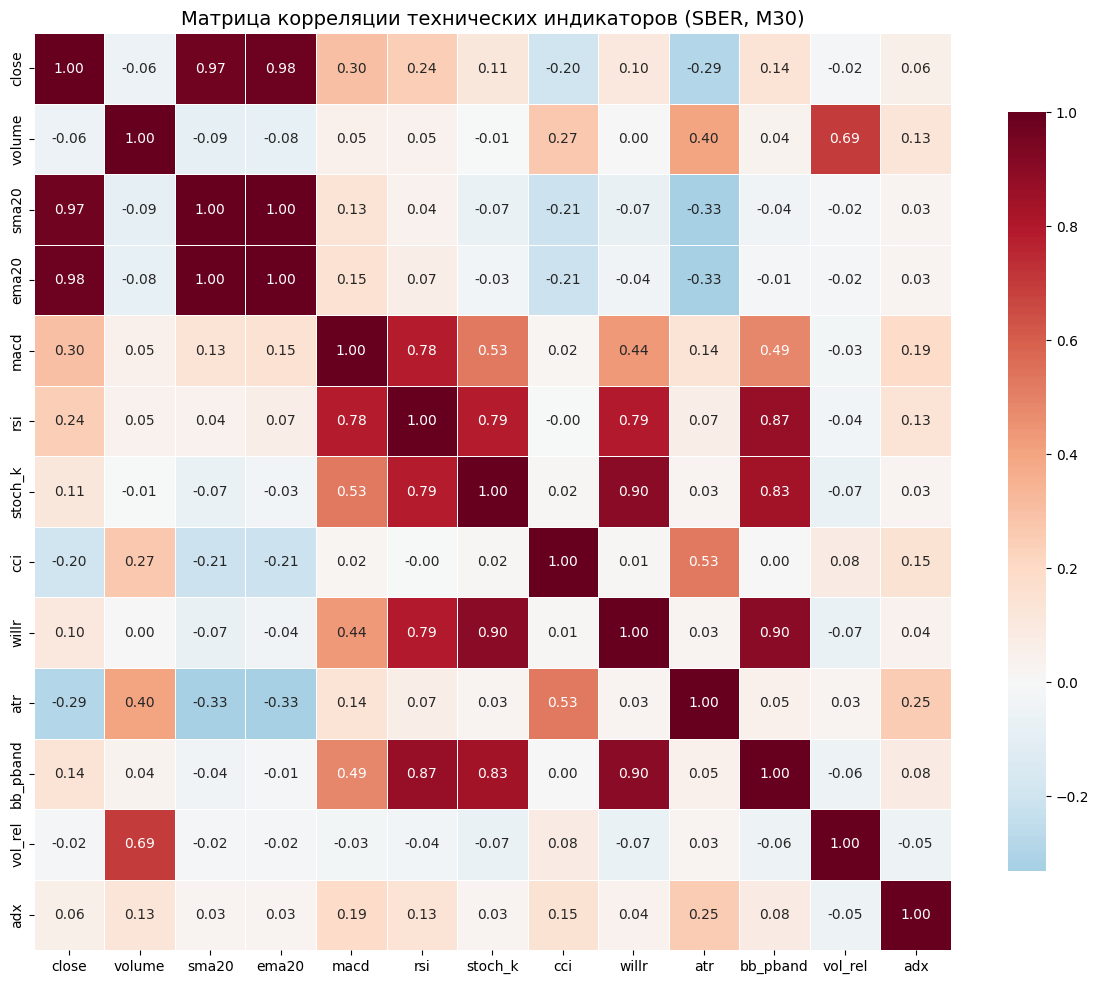


Ключевые наблюдения:
• SMA20 и EMA20 имеют корреляцию ~1 (практически одинаковы)
• RSI и Stochastic коррелируют (оба измеряют момент)
• Williams %R и Stochastic сильно коррелируют (схожая формула)
• ADX слабо коррелирует с остальными (измеряет силу тренда, не направление)


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Выбираем ключевые индикаторы для анализа корреляции
indicator_cols = [
    'close', 'volume', 'sma20', 'ema20', 'macd', 'rsi', 
    'stoch_k', 'cci', 'willr', 'atr', 'bb_pband', 'vol_rel', 'adx'
]

# Фильтруем только существующие столбцы
available_cols = [col for col in indicator_cols if col in df.columns]
df_indicators = df[available_cols].dropna()

# Рассчитываем матрицу корреляции
corr_matrix = df_indicators.corr()

# Визуализация
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt='.2f', 
    cmap='RdBu_r',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)
plt.title('Матрица корреляции технических индикаторов (SBER, M30)', fontsize=14)
plt.tight_layout()
plt.show()

print("\nКлючевые наблюдения:")
print("• SMA20 и EMA20 имеют корреляцию ~1 (практически одинаковы)")
print("• RSI и Stochastic коррелируют (оба измеряют момент)")
print("• Williams %R и Stochastic сильно коррелируют (схожая формула)")
print("• ADX слабо коррелирует с остальными (измеряет силу тренда, не направление)")


### Запуск сборщика данных

Для обновления данных выполните:

```bash
python scripts/data_collector.py
```

Скрипт автоматически:
1. Загрузит новые свечи для всех инструментов и таймфреймов
2. Объединит с существующими данными
3. Пересчитает технические индикаторы
4. Сохранит результаты в Parquet-файлы

---

*Далее: Генерация торговых сигналов*


## 3. Генерация торговых сигналов

Для генерации надёжных торговых сигналов используется **5-уровневая система фильтрации**. Каждый уровень последовательно проверяет условия входа в позицию.

### Архитектура системы фильтрации

```mermaid
graph TD;
    A[Уровень 1: Режим рынка] --> B[Уровень 2: Тренд]
    B --> C[Уровень 3: Волатильность]
    C --> D[Уровень 4: Объёмы + Паттерны]
    D --> E[Уровень 5: Осцилляторы]
```

```
┌─────────────────────────────────────────────────────────────────┐
│                    ВХОДНЫЕ ДАННЫЕ (OHLCV + Индикаторы)          │
└─────────────────────────────────────────────────────────────────┘
                              │
                              ▼
              ┌───────────────────────────────┐
              │   Уровень 1: РЕЖИМ РЫНКА      │
              │   (market_regime)             │
              │   Проходит ли рынок для       │
              │   торговли?                   │
              │   • Волатильность             │
              │   • Тренд (ADX)               │
              │   • Ликвидность               │
              └───────────────────────────────┘
                              │
                              ▼
              ┌───────────────────────────────┐
              │   Уровень 2: ТРЕНД            │
              │   Какое направление движения? │
              │   • EMA (10, 20, 50)          │
              │   • MACD                      │
              │   • Положение цены            │
              └───────────────────────────────┘
                              │
                              ▼
              ┌───────────────────────────────┐
              │   Уровень 3: ВОЛАТИЛЬНОСТЬ    │
              │   Подходящие ли условия?      │
              │   • ATR / ATR_SMA50           │
              │   • Сжатие полос Боллинджера  │
              └───────────────────────────────┘
                              │
                              ▼
              ┌───────────────────────────────┐
              │   Уровень 4: ОБЪЁМЫ + ПАТТЕРНЫ│
              │   Есть ли подтверждение?      │
              │   • Относительный объём       │
              │   • Свечные паттерны          │
              └───────────────────────────────┘
                              │
                              ▼
              ┌───────────────────────────────┐
              │   Уровень 5: ОСЦИЛЛЯТОРЫ      │
              │   Финальное подтверждение     │
              │   • RSI                       │
              │   • Stochastic                │
              │   • CCI                       │
              │   • Williams %R               │
              └───────────────────────────────┘
                              │
                              ▼
              ┌───────────────────────────────┐
              │        ИТОГОВЫЙ СИГНАЛ        │
              │   STRONG_BUY / BUY / NEUTRAL  │
              │   SELL / STRONG_SELL          │
              └───────────────────────────────┘
```


In [10]:
# Импорт генератора сигналов
from scripts.signal_generator import SignalGenerator, SignalConfig, SignalType

# Создание генератора с настройками по умолчанию
generator = SignalGenerator()

print("Генератор сигналов инициализирован")
print(f"Количество фильтров: {len(generator.filters)}")
for f in generator.filters:
    print(f"  Уровень {f.level}: {f.name}")


Генератор сигналов инициализирован
Количество фильтров: 5
  Уровень 1: Market Regime
  Уровень 2: Trend
  Уровень 3: Volatility
  Уровень 4: Volume + Patterns
  Уровень 5: Oscillators


### Демонстрация генерации сигналов

Рассмотрим генерацию сигналов на примере акций Сбербанка (SBER) на дневном таймфрейме:


In [11]:
# Генерация сигналов для SBER (последние 20 свечей)
signals_df = generator.generate_signals_df("SBER", "M30", last_n=20)

# Отображение результатов
display_cols = ["signal", "strength", "price", 
                "filter_Market Regime", "filter_Trend", 
                "filter_Volatility", "filter_Volume + Patterns", 
                "filter_Oscillators"]

print("Сигналы SBER (M30), последние 20 свечей:")
signals_df[display_cols]


2025-12-13 12:38:08 | INFO     | Загружено 1999 свечей для SBER/M30
2025-12-13 12:38:08 | INFO     | Сгенерировано сигналов: 7 из 20 свечей


Сигналы SBER (M30), последние 20 свечей:


,signal,strength,price,filter_Market Regime,filter_Trend,filter_Volatility,filter_Volume + Patterns,filter_Oscillators
time,,,,,,,,
2025-12-12 12:00:00+00:00,NEUTRAL,2,306.00,0,-1,1,0,0
2025-12-12 12:30:00+00:00,BUY,3,305.13,0,-1,1,0,1
2025-12-12 13:00:00+00:00,BUY,3,304.84,0,-1,1,0,1
2025-12-12 13:30:00+00:00,NEUTRAL,2,305.16,0,-1,1,0,0
2025-12-12 14:00:00+00:00,BUY,3,305.37,0,-1,1,0,1
2025-12-12 14:30:00+00:00,NEUTRAL,4,305.01,-1,-1,1,0,1
2025-12-12 15:00:00+00:00,NEUTRAL,4,305.02,-1,-1,1,0,1
2025-12-12 15:30:00+00:00,BUY,3,305.02,0,-1,1,0,1
2025-12-12 16:00:00+00:00,NEUTRAL,4,304.51,-1,-1,1,0,1


### Сканирование всех инструментов

Генератор позволяет сканировать все инструменты из конфигурации и находить активные сигналы:


In [12]:
# Сканирование всех инструментов на дневном таймфрейме
scan_results = generator.scan_all_instruments(timeframe="M30", min_strength=3)

print(f"Найдено активных сигналов: {len(scan_results)}")
if not scan_results.empty:
    print("\nАктивные сигналы:")
    scan_results[["ticker", "signal", "strength", "price"]]


2025-12-13 12:38:08 | INFO     | Загружено 1594 свечей для AFKS/M30
2025-12-13 12:38:08 | INFO     | Сгенерировано сигналов: 0 из 1 свечей
2025-12-13 12:38:08 | INFO     | Загружено 1601 свечей для AFLT/M30
2025-12-13 12:38:08 | INFO     | Сгенерировано сигналов: 1 из 1 свечей
2025-12-13 12:38:08 | INFO     | Загружено 1600 свечей для ALRS/M30
2025-12-13 12:38:08 | INFO     | Сгенерировано сигналов: 0 из 1 свечей
2025-12-13 12:38:08 | INFO     | Загружено 1796 свечей для ASTR/M30
2025-12-13 12:38:08 | INFO     | Сгенерировано сигналов: 0 из 1 свечей
2025-12-13 12:38:08 | INFO     | Загружено 1979 свечей для BSPB/M30
2025-12-13 12:38:08 | INFO     | Сгенерировано сигналов: 0 из 1 свечей
2025-12-13 12:38:08 | INFO     | Загружено 1931 свечей для CBOM/M30
2025-12-13 12:38:08 | INFO     | Сгенерировано сигналов: 1 из 1 свечей
2025-12-13 12:38:08 | INFO     | Загружено 1995 свечей для CHMF/M30
2025-12-13 12:38:08 | INFO     | Сгенерировано сигналов: 1 из 1 свечей
2025-12-13 12:38:08 | INFO 

Найдено активных сигналов: 27

Активные сигналы:


### Описание уровней фильтрации

#### Уровень 1: Режим рынка (Market Regime)

Определяет общее состояние рынка на основе комбинации трёх факторов:

| Код | Волатильность | Тренд | Ликвидность | Описание |
|-----|---------------|-------|-------------|----------|
| 000 | Низкая | Боковой | Низкая | Спокойный рынок, мало движения |
| 001 | Низкая | Боковой | Высокая | Спокойный рынок с объёмами |
| 011 | Низкая | Тренд | Высокая | **Хороший тренд** ✓ |
| 111 | Высокая | Тренд | Высокая | **Сильный тренд** ✓ |
| 100 | Высокая | Боковой | Низкая | Волатильный боковик (опасно) |

**Благоприятные режимы для торговли:** 011, 111


#### Уровень 2: Тренд (Trend)

Определение направления движения:

| Условие | Сигнал |
|---------|--------|
| EMA10 > EMA20 > EMA50, цена > EMA20, MACD > Signal | **BUY** (восходящий тренд) |
| EMA10 < EMA20 < EMA50, цена < EMA20, MACD < Signal | **SELL** (нисходящий тренд) |
| Смешанные условия | **NEUTRAL** (боковой тренд) |

#### Уровень 3: Волатильность (Volatility)

| Условие | Оценка |
|---------|--------|
| Сжатие полос Боллинджера (BB width < 2%) | Благоприятно (ожидается пробой) |
| ATR / ATR_SMA50 > 2.0 | Опасно (слишком высокая волатильность) |
| 0.8 ≤ ATR / ATR_SMA50 ≤ 1.5 | Нормально |

#### Уровень 4: Объёмы + Паттерны (Volume + Patterns)

- Относительный объём ≥ 120% от средней → подтверждение
- Бычьи паттерны (hammer, bullish engulfing) + высокий объём → **BUY**
- Медвежьи паттерны (bearish engulfing) + высокий объём → **SELL**

#### Уровень 5: Осцилляторы (Oscillators)

Финальное подтверждение от 4 осцилляторов (нужно минимум 2 совпадения):

| Осциллятор | Перепроданность (BUY) | Перекупленность (SELL) |
|------------|----------------------|------------------------|
| RSI | < 30 | > 70 |
| Stochastic | %K < 20, %K > %D | %K > 80, %K < %D |
| CCI | < -100 | > 100 |
| Williams %R | < -80 | > -20 |


### Итоговый сигнал

| Сила (strength) | Условие | Сигнал |
|-----------------|---------|--------|
| ≥ 4 из 5 | Большинство фильтров положительные | **STRONG_BUY** или **STRONG_SELL** |
| 3 из 5 | Минимальное подтверждение | **BUY** или **SELL** |
| < 3 | Недостаточно подтверждений | **NEUTRAL** (не торговать) |

---

*Далее: Обучение нейросетевой модели для прогнозирования*
